In [2]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import math

from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [39]:
df = pd.read_csv('day.csv')
df

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0          1  01-01-2018       1   0     1        0        6           0   
1          2  02-01-2018       1   0     1        0        0           0   
2          3  03-01-2018       1   0     1        0        1           1   
3          4  04-01-2018       1   0     1        0        2           1   
4          5  05-01-2018       1   0     1        0        3           1   
..       ...         ...     ...  ..   ...      ...      ...         ...   
725      726  27-12-2019       1   1    12        0        4           1   
726      727  28-12-2019       1   1    12        0        5           1   
727      728  29-12-2019       1   1    12        0        6           0   
728      729  30-12-2019       1   1    12        0        0           0   
729      730  31-12-2019       1   1    12        0        1           1   

     weathersit       temp     atemp      hum  windspeed  casual  registered  \
0             2  14.110847  18.18125  80.5833  10.749882     331         654   
1             2  14.902598  17.68695  69.6087  16.652113     131         670   
2             1   8.050924   9.47025  43.7273  16.636703     120        1229   
3             1   8.200000  10.60610  59.0435  10.739832     108        1454   
4             1   9.305237  11.46350  43.6957  12.522300      82        1518   
..          ...        ...       ...      ...        ...     ...         ...   
725           2  10.420847  11.33210  65.2917  23.458911     247        1867   
726           2  10.386653  12.75230  59.0000  10.416557     644        2451   
727           2  10.386653  12.12000  75.2917   8.333661     159        1182   
728           1  10.489153  11.58500  48.3333  23.500518     364        1432   
729           2   8.849153  11.17435  57.7500  10.374682     439        2290   

      cnt  
0     985  
1     801  
2    1349  
3    1562  
4    1600  
..    ...  
725  2114  
726  3095  
727  1341  
728  1796  
729  2729  

[730 rows x 16 columns]

In [45]:
#Importing the dataset
df = pd.read_csv('day.csv')

df.drop(['dteday','instant','casual','registered'], axis=1, inplace=True)
df.head()

target = 'cnt'
features = [i for i in df.columns if i not in [target]]

original_df = df.copy(deep=True)


In [41]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


In [43]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=16:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 4 numerical & 7 categorical features.


In [46]:
df.describe()

season          yr        mnth     holiday     weekday  workingday  \
count  730.000000  730.000000  730.000000  730.000000  730.000000  730.000000   
mean     2.498630    0.500000    6.526027    0.028767    2.997260    0.683562   
std      1.110184    0.500343    3.450215    0.167266    2.006161    0.465405   
min      1.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
25%      2.000000    0.000000    4.000000    0.000000    1.000000    0.000000   
50%      3.000000    0.500000    7.000000    0.000000    3.000000    1.000000   
75%      3.000000    1.000000   10.000000    0.000000    5.000000    1.000000   
max      4.000000    1.000000   12.000000    1.000000    6.000000    1.000000   

       weathersit        temp       atemp         hum   windspeed          cnt  
count  730.000000  730.000000  730.000000  730.000000  730.000000   730.000000  
mean     1.394521   20.319259   23.726322   62.765175   12.763620  4508.006849  
std      0.544807    7.506729    8.150308   14.237589    5.195841  1936.011647  
min      1.000000    2.424346    3.953480    0.000000    1.500244    22.000000  
25%      1.000000   13.811885   16.889713   52.000000    9.041650  3169.750000  
50%      1.000000   20.465826   24.368225   62.625000   12.125325  4548.500000  
75%      2.000000   26.880615   30.445775   72.989575   15.625589  5966.000000  
max      3.000000   35.328347   42.044800   97.250000   34.000021  8714.000000

# <center>  Exploratory Data Analysis (EDA)

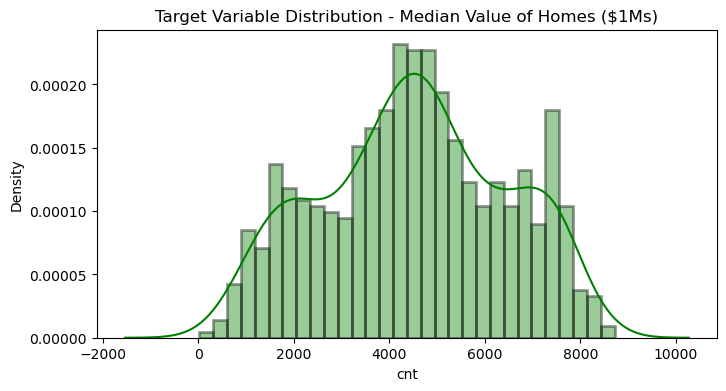

In [47]:
# analyze the distribution of the target variable
plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

**Inference:**The Target Variable seems to be be normally distributed, averaging around 20 units.

**Inference:** There are no categorical features in the dataset.

                                                Numeric Features Distribution                                                 


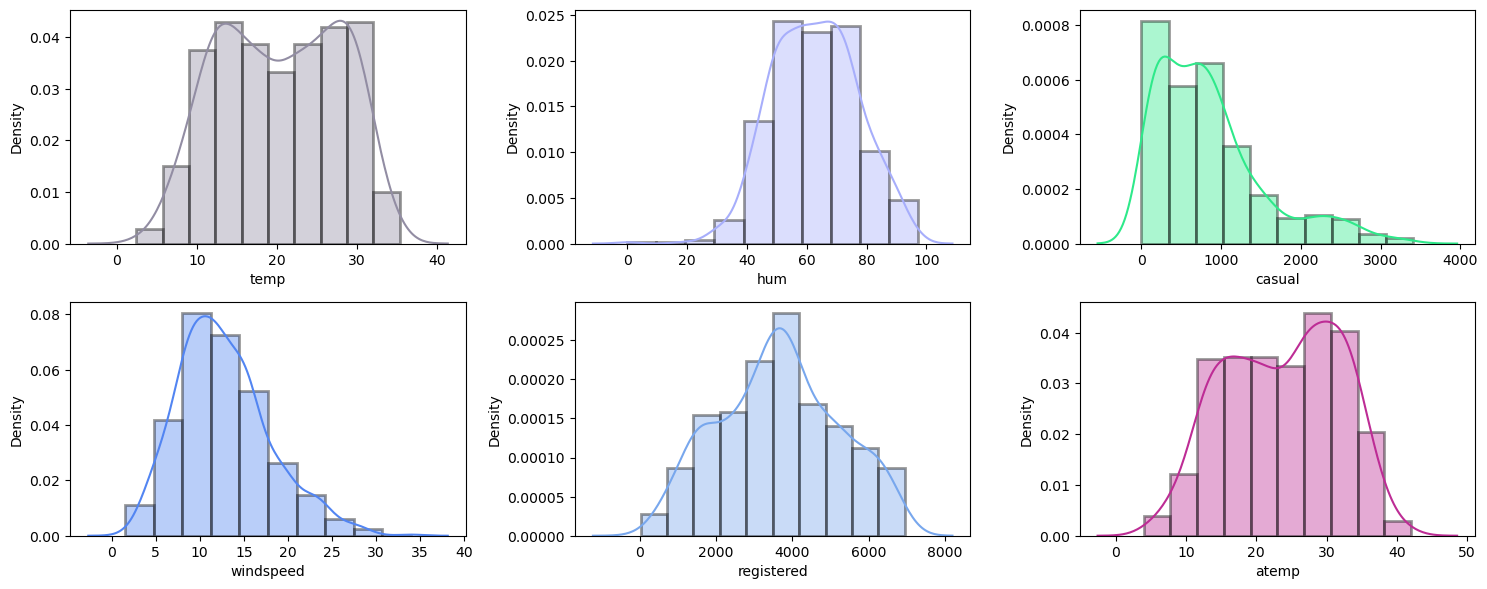

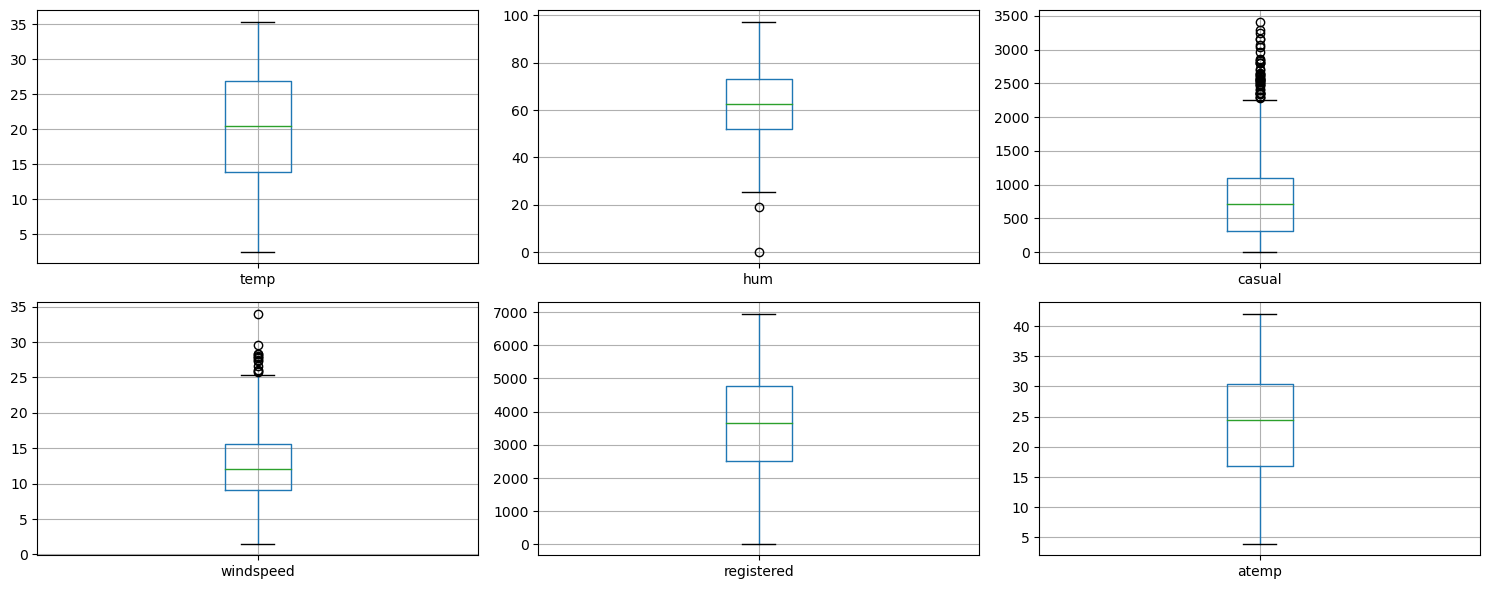

In [10]:
#Visualising the numeric features 

print('\033[1mNumeric Features Distribution'.center(130))

n=3

clr=['r','g','b','g','b','r']

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

**Inference:** There seem to be some outliers. let us fix these in the upcoming section...

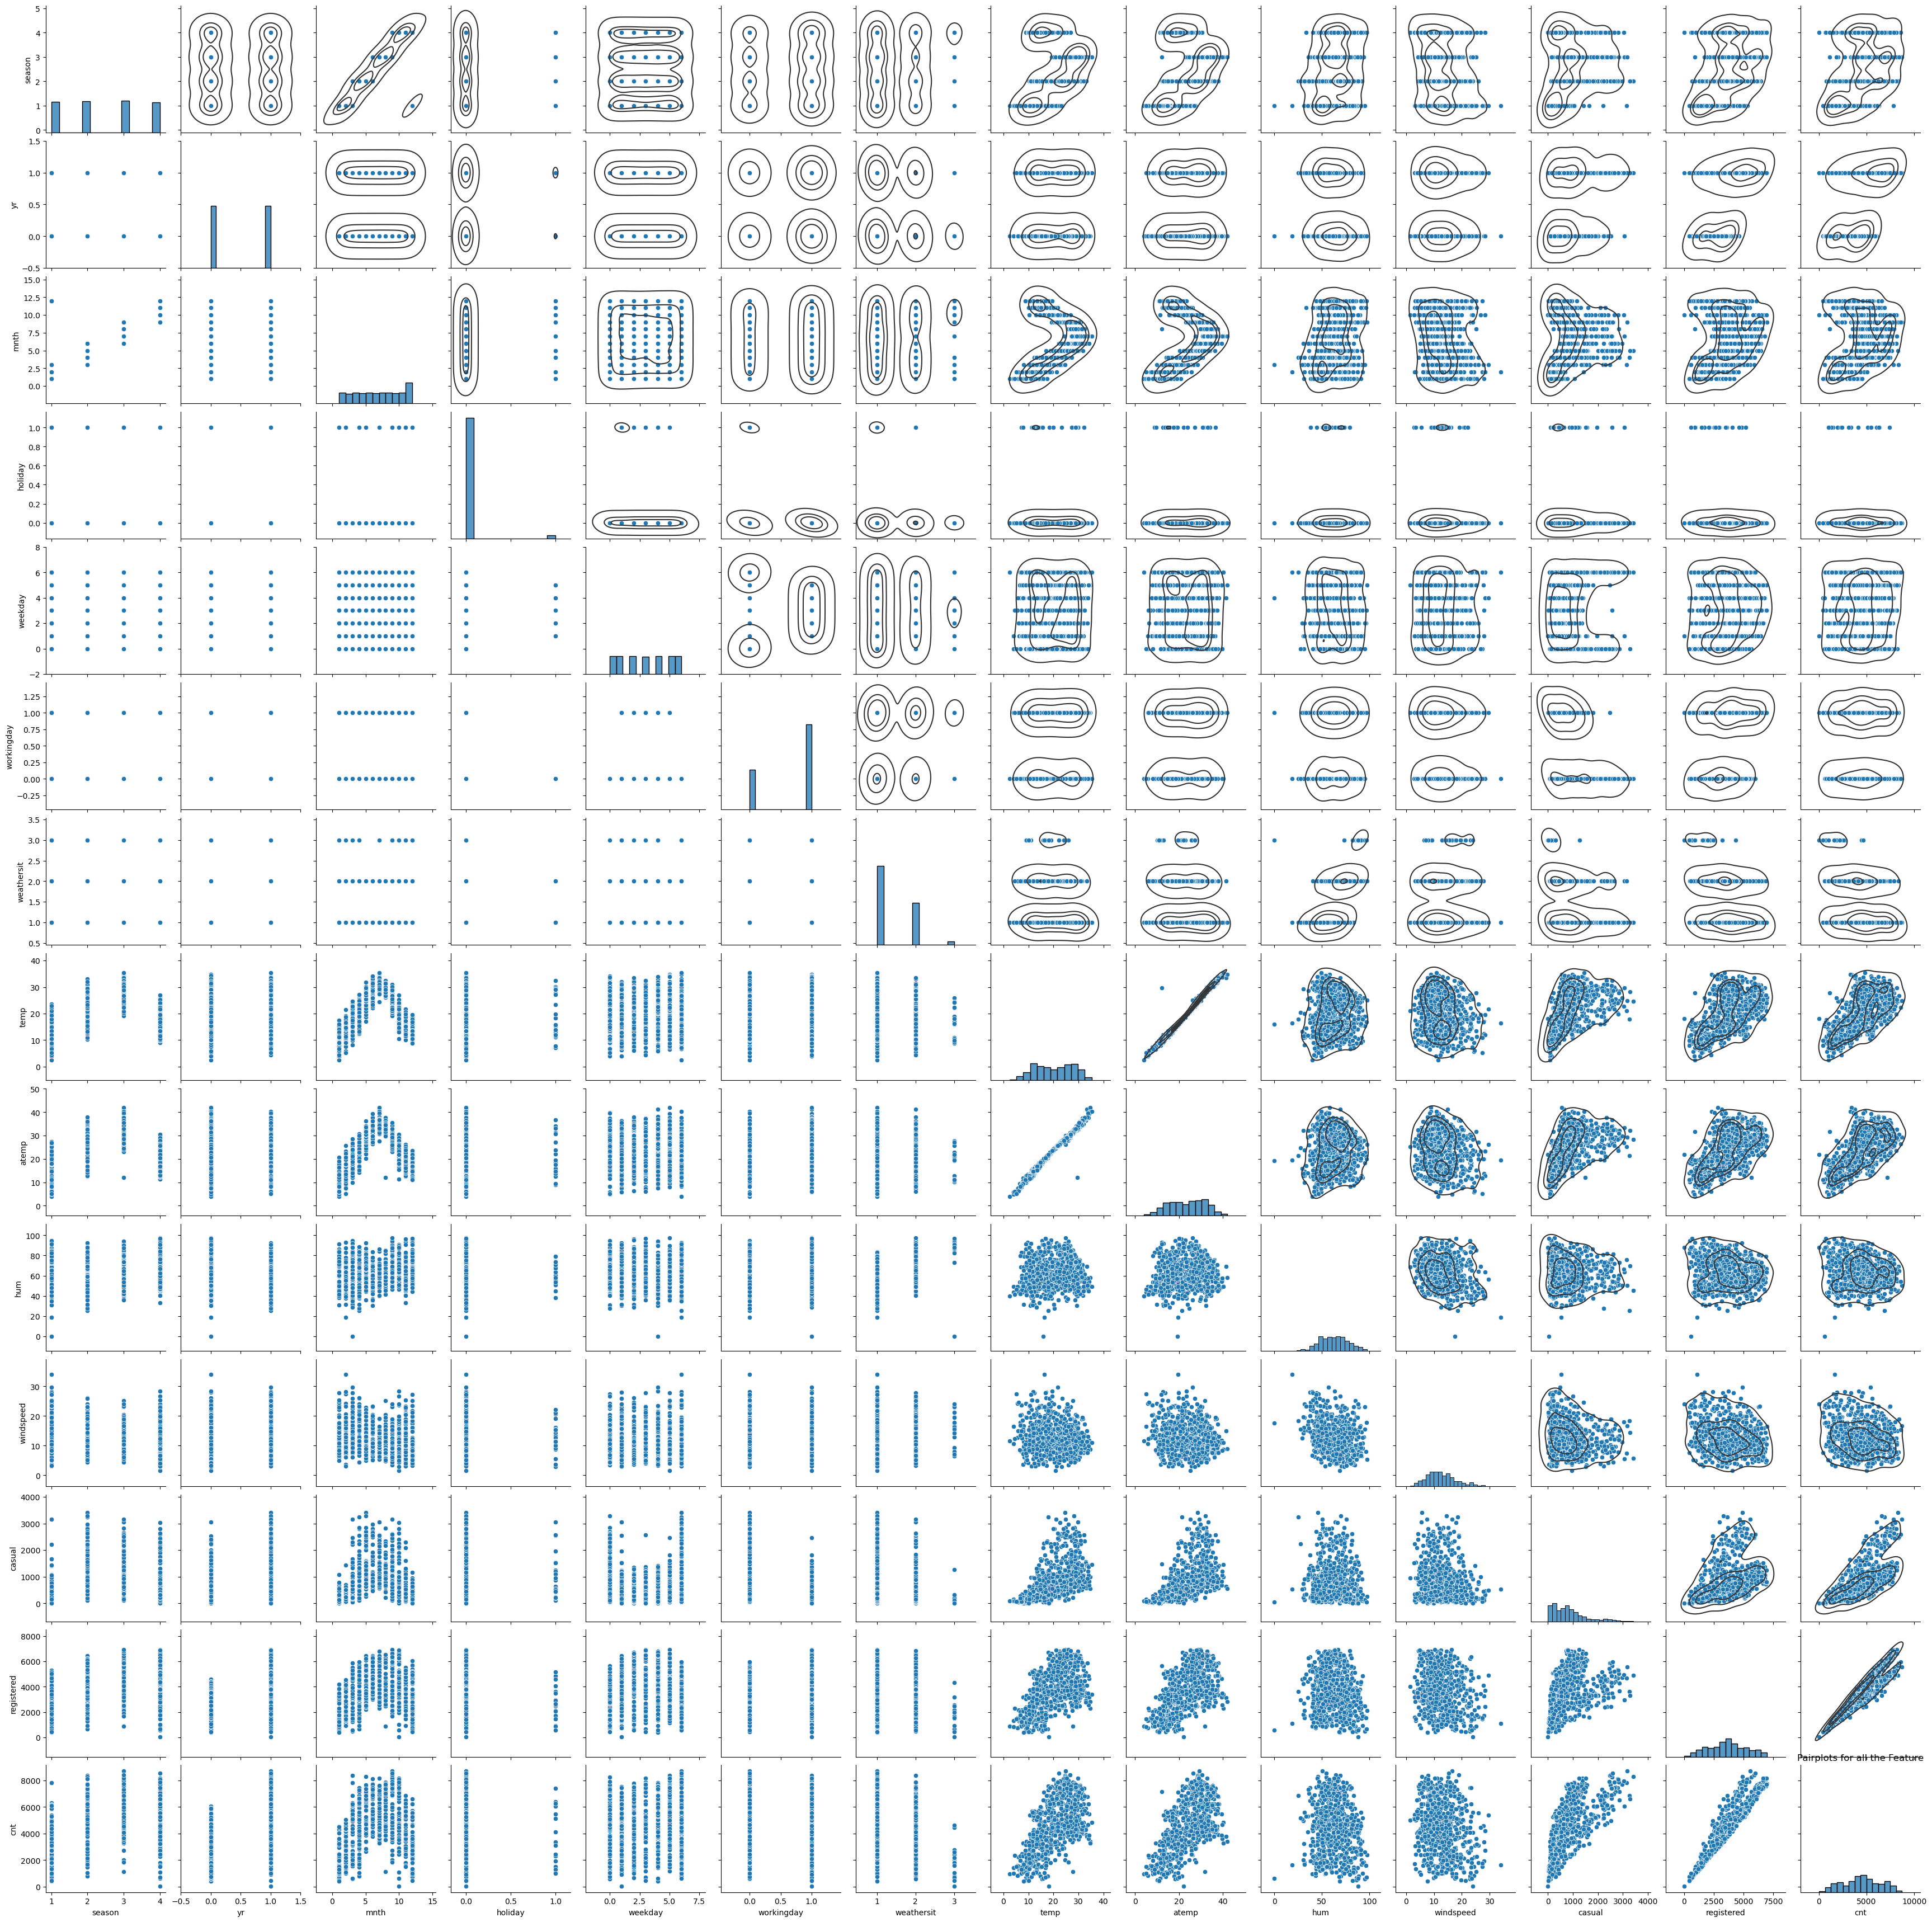

In [14]:
#Understanding the relationship between all the features
g = sns.pairplot(df)
plt.title('Pairplots for all the Feature')
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()

**Inference:** We can notice that some features have linear relationship, let us futher analyze the detect multicollinearity.

<Axes: xlabel='temp', ylabel='cnt'>

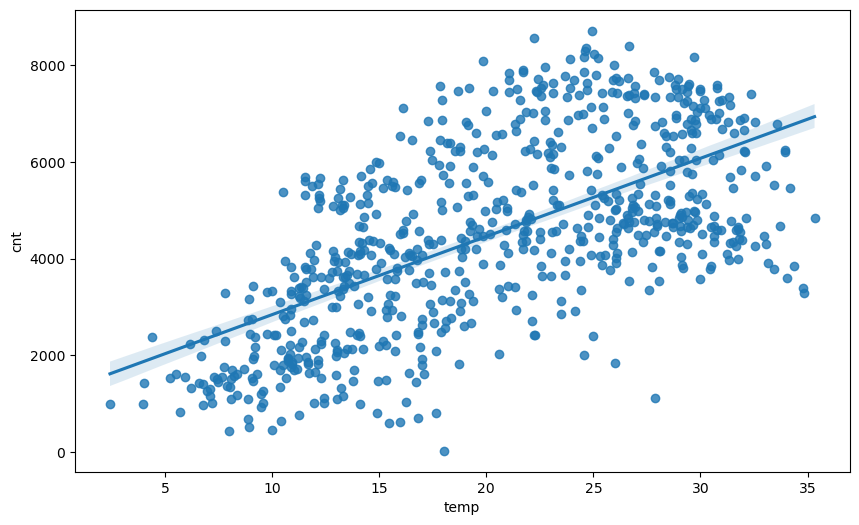

In [48]:
sns.regplot(x="temp",y="cnt",data=df)

---

# <center> Data Preprocessing

In [15]:
#Removal of any Duplicate rows (if any)

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [16]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

            Total Null Values  Percentage
season                      0         0.0
yr                          0         0.0
mnth                        0         0.0
holiday                     0         0.0
weekday                     0         0.0
workingday                  0         0.0
weathersit                  0         0.0
temp                        0         0.0
atemp                       0         0.0
hum                         0         0.0
windspeed                   0         0.0
casual                      0         0.0
registered                  0         0.0
cnt                         0         0.0


**Inference:** The datset doesn't have any inconsistant values.

In [17]:
#Converting categorical Columns to Numeric

df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape

One-Hot Encoding on features:
yr
holiday
workingday

Dummy Encoding on features:
weathersit
season
weekday
mnth


(730, 32)

In [18]:
#Removal of outlier:

df1 = df3.copy()

features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

yr  holiday  workingday       temp     atemp      hum  windspeed  casual  \
0   0        0           0  14.110847  18.18125  80.5833  10.749882     331   
1   0        0           0  14.902598  17.68695  69.6087  16.652113     131   
2   0        0           1   8.050924   9.47025  43.7273  16.636703     120   
3   0        0           1   8.200000  10.60610  59.0435  10.739832     108   
4   0        0           1   9.305237  11.46350  43.6957  12.522300      82   

   registered   cnt  ...  mnth_3  mnth_4  mnth_5  mnth_6  mnth_7  mnth_8  \
0         654   985  ...       0       0       0       0       0       0   
1         670   801  ...       0       0       0       0       0       0   
2        1229  1349  ...       0       0       0       0       0       0   
3        1454  1562  ...       0       0       0       0       0       0   
4        1518  1600  ...       0       0       0       0       0       0   

   mnth_9  mnth_10  mnth_11  mnth_12  
0       0        0        0        0  
1       0        0        0        0  
2       0        0        0        0  
3       0        0        0        0  
4       0        0        0        0  

[5 rows x 32 columns]


Inference:
Before removal of outliers, The dataset had 730 samples.
After removal of outliers, The dataset now has 672 samples.


---

# <center>  Data Manipulation

In [20]:
#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (672, 31) (672,) 
Training set  --->  (537, 31) (537,) 
Testing set   --->  (135, 31)  (135,)


In [21]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


yr       holiday    workingday          temp         atemp  \
count  5.370000e+02  5.370000e+02  5.370000e+02  5.370000e+02  5.370000e+02   
mean   3.969512e-17  1.653964e-17 -3.307927e-17  3.142531e-17 -1.488567e-16   
std    1.000932e+00  1.000932e+00  1.000932e+00  1.000932e+00  1.000932e+00   
min   -9.263539e-01 -1.636113e-01 -1.644217e+00 -2.286119e+00 -2.323698e+00   
25%   -9.263539e-01 -1.636113e-01 -1.644217e+00 -8.576950e-01 -8.497981e-01   
50%   -9.263539e-01 -1.636113e-01  6.081924e-01 -9.448390e-02 -2.696842e-02   
75%    1.079501e+00 -1.636113e-01  6.081924e-01  9.008183e-01  8.527429e-01   
max    1.079501e+00  6.112049e+00  6.081924e-01  2.012161e+00  2.251741e+00   

                hum     windspeed        casual    registered  weathersit_2  \
count  5.370000e+02  5.370000e+02  5.370000e+02  5.370000e+02  5.370000e+02   
mean   3.605641e-16 -2.646342e-17 -4.465702e-17  1.488567e-16  6.615854e-18   
std    1.000932e+00  1.000932e+00  1.000932e+00  1.000932e+00  1.000932e+00   
min   -2.487149e+00 -2.286649e+00 -1.411974e+00 -2.269189e+00 -6.952880e-01   
25%   -7.718838e-01 -7.298249e-01 -8.581299e-01 -7.297237e-01 -6.952880e-01   
50%   -3.761584e-02 -9.691080e-02 -8.739574e-02 -8.059751e-03 -6.952880e-01   
75%    7.172211e-01  6.128465e-01  5.768299e-01  6.781851e-01  1.438253e+00   
max    2.423668e+00  2.588831e+00  2.956811e+00  2.111393e+00  1.438253e+00   

       ...        mnth_3        mnth_4        mnth_5        mnth_6  \
count  ...  5.370000e+02  5.370000e+02  5.370000e+02  5.370000e+02   
mean   ... -9.923781e-18 -4.300305e-17  5.954269e-17 -1.653964e-18   
std    ...  1.000932e+00  1.000932e+00  1.000932e+00  1.000932e+00   
min    ... -3.133042e-01 -2.798451e-01 -2.912876e-01 -2.680602e-01   
25%    ... -3.133042e-01 -2.798451e-01 -2.912876e-01 -2.680602e-01   
50%    ... -3.133042e-01 -2.798451e-01 -2.912876e-01 -2.680602e-01   
75%    ... -3.133042e-01 -2.798451e-01 -2.912876e-01 -2.680602e-01   
max    ...  3.191786e+00  3.573406e+00  3.433033e+00  3.730505e+00   

             mnth_7        mnth_8        mnth_9       mnth_10       mnth_11  \
count  5.370000e+02  5.370000e+02  5.370000e+02  5.370000e+02  5.370000e+02   
mean   4.961891e-18  5.292683e-17 -3.804116e-17  4.961891e-17  5.623476e-17   
std    1.000932e+00  1.000932e+00  1.000932e+00  1.000932e+00  1.000932e+00   
min   -3.168751e-01 -3.204207e-01 -2.836951e-01 -2.912876e-01 -3.239418e-01   
25%   -3.168751e-01 -3.204207e-01 -2.836951e-01 -2.912876e-01 -3.239418e-01   
50%   -3.168751e-01 -3.204207e-01 -2.836951e-01 -2.912876e-01 -3.239418e-01   
75%   -3.168751e-01 -3.204207e-01 -2.836951e-01 -2.912876e-01 -3.239418e-01   
max    3.155817e+00  3.120897e+00  3.524911e+00  3.433033e+00  3.086975e+00   

            mnth_12  
count  5.370000e+02  
mean  -3.307927e-18  
std    1.000932e+00  
min   -3.168751e-01  
25%   -3.168751e-01  
50%   -3.168751e-01  
75%   -3.168751e-01  
max    3.155817e+00  

[8 rows x 31 columns]


                                          Standardardization on Testing set                                          


yr     holiday  workingday        temp       atemp         hum  \
count  135.000000  135.000000  135.000000  135.000000  135.000000  135.000000   
mean     0.128577    0.022334   -0.025819    0.097623    0.099003    0.137586   
std      1.005309    1.068085    1.016730    0.953623    0.939262    0.939658   
min     -0.926354   -0.163611   -1.644217   -2.085856   -2.204964   -2.237494   
25%     -0.926354   -0.163611   -1.644217   -0.721565   -0.684823   -0.554541   
50%      1.079501   -0.163611    0.608192    0.191166    0.253632    0.135677   
75%      1.079501   -0.163611    0.608192    0.896352    0.856560    0.778896   
max      1.079501    6.112049    0.608192    1.864874    1.925724    2.408985   

        windspeed      casual  registered  weathersit_2  ...      mnth_3  \
count  135.000000  135.000000  135.000000    135.000000  ...  135.000000   
mean    -0.135094    0.084897    0.074969      0.189736  ...   -0.131559   
std      0.977444    1.057592    0.988668      1.055089  ...    0.780071   
min     -1.867442   -1.342259   -1.919426     -0.695288  ...   -0.313304   
25%     -0.812458   -0.762272   -0.643073     -0.695288  ...   -0.313304   
50%     -0.293537   -0.131936    0.100727     -0.695288  ...   -0.313304   
75%      0.467516    0.596195    0.756929      1.438253  ...   -0.313304   
max      2.605845    2.935509    2.089256      1.438253  ...    3.191786   

           mnth_4      mnth_5      mnth_6      mnth_7      mnth_8      mnth_9  \
count  135.000000  135.000000  135.000000  135.000000  135.000000  135.000000   
mean     0.119751    0.039763    0.235463   -0.136810   -0.065508    0.054848   
std      1.179138    1.063827    1.331528    0.772860    0.904608    1.087903   
min     -0.279845   -0.291288   -0.268060   -0.316875   -0.320421   -0.283695   
25%     -0.279845   -0.291288   -0.268060   -0.316875   -0.320421   -0.283695   
50%     -0.279845   -0.291288   -0.268060   -0.316875   -0.320421   -0.283695   
75%     -0.279845   -0.291288   -0.268060   -0.316875   -0.320421   -0.283695   
max      3.573406    3.433033    3.730505    3.155817    3.120897    3.524911   

          mnth_10     mnth_11     mnth_12  
count  135.000000  135.000000  135.000000  
mean     0.094938   -0.121813   -0.008191  
std      1.139684    0.808348    0.991951  
min     -0.291288   -0.323942   -0.316875  
25%     -0.291288   -0.323942   -0.316875  
50%     -0.291288   -0.323942   -0.316875  
75%     -0.291288   -0.323942   -0.316875  
max      3.433033    3.086975    3.155817  

[8 rows x 31 columns]

# <center> Feature Selection

                                       Correlation Matrix                                       


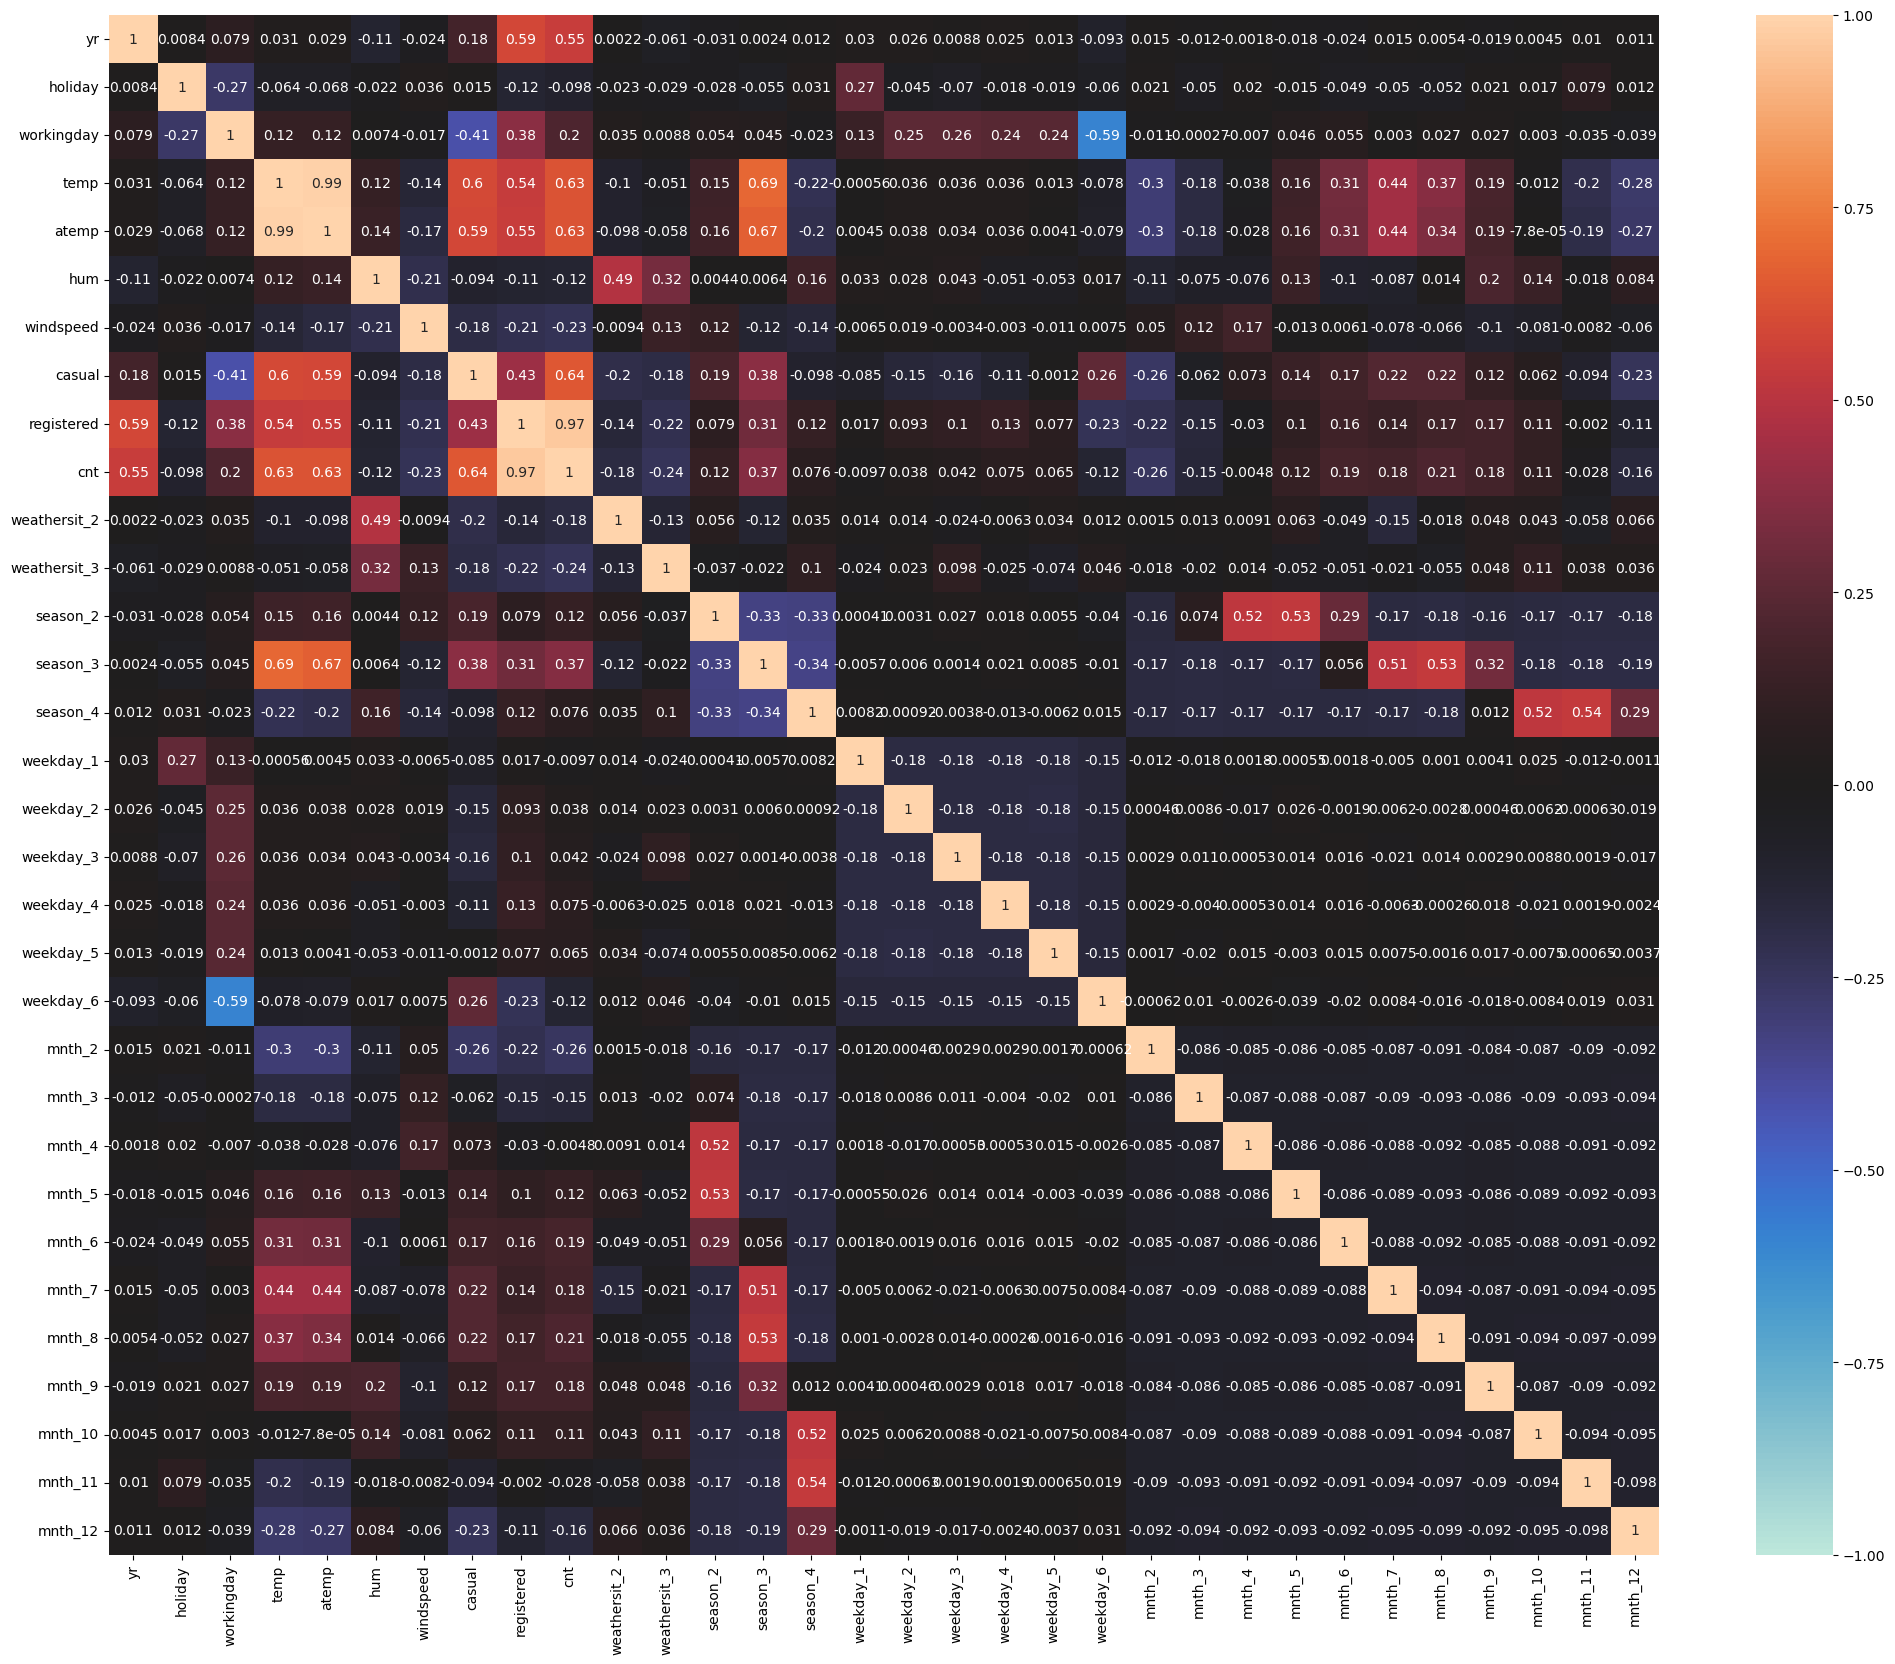

In [22]:
#Checking the correlation
print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[25,20])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0)
plt.show()

**Inference:** There seems to be strong multi-correlation between the features. Let us try to fix these...

#Testing a Linear Regression model with statsmodels

Train_xy = pd.concat([Train_X_std,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()

API.summary()

 ---

## Manual Method - VIF

Dropped Features -->  ['weekday_2', 'temp', 'season_3', 'registered', 'atemp', 'season_4', 'season_2', 'workingday', 'casual', 'hum', 'mnth_7', 'weekday_1', 'mnth_12', 'mnth_3', 'weekday_3', 'mnth_10', 'mnth_4', 'weekday_6', 'mnth_8', 'weathersit_3', 'mnth_5', 'weekday_4', 'mnth_9', 'mnth_6', 'holiday', 'weathersit_2', 'mnth_2']


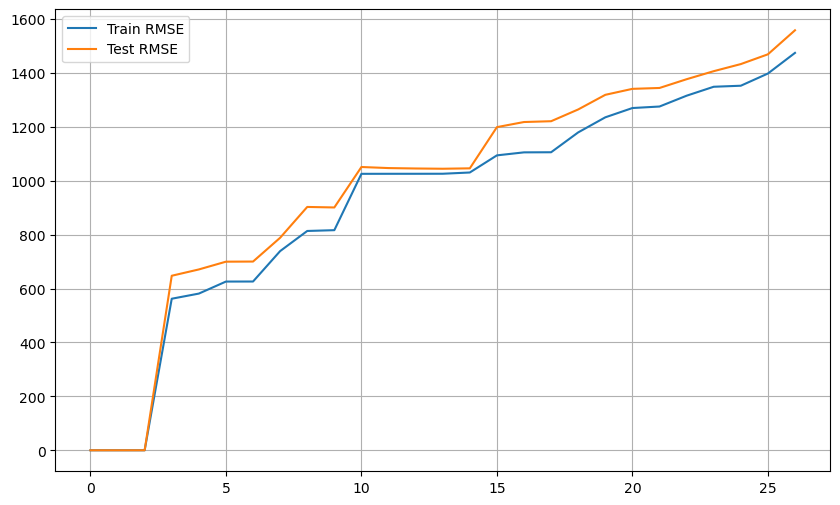

In [24]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
DROP=[];b=[]

for i in range(len(Train_X_std.columns)):
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)

        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))
        
        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))
        
print('Dropped Features --> ',DROP)
plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

## Automatic Method - RFE

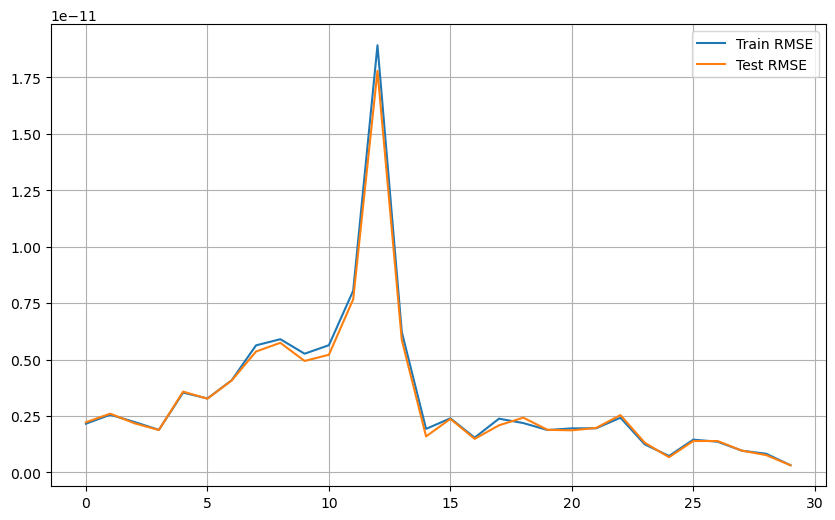

In [25]:
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

m=df.shape[1]-2
for i in range(m):
    lm = LinearRegression()
    rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-i)            
    rfe = rfe.fit(Train_X_std, Train_Y)

    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

    pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

## Feature Elmination using PCA Decomposition

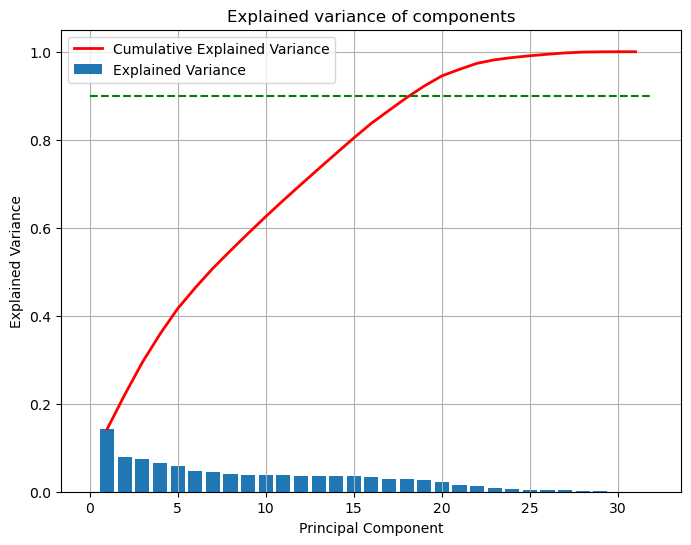

In [26]:
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()

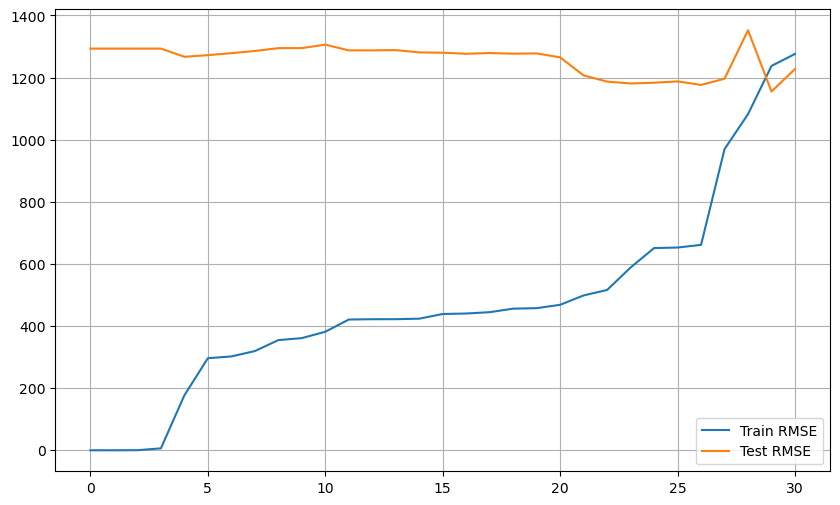

In [27]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
m=df.shape[1]-1

for i in range(m):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Test_X_std_pca = pca.fit_transform(Test_X_std)
    
    LR = LinearRegression()
    LR.fit(Train_X_std_pca, Train_Y)

    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)

    Trr.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),2))
    Tss.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),2))

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

#### Inference:
It can be seen that the performance of the modelsis quiet comparable unpon dropping features using VIF, RFE & PCA Techniques. Comparing the RMSE plots, the optimal values were found for dropping most  features using manual RFE Technique. But let us skip these for now, as the advanced ML Algorithms take care of multicollinearity.

In [28]:
# #Shortlisting the selected Features (with RFE)

lm = LinearRegression()
rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-df.shape[1]+3)  
rfe = rfe.fit(Train_X_std, Train_Y)

LR = LinearRegression()
LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

print(np.sqrt(mean_squared_error(Train_Y, pred1)))
print(np.sqrt(mean_squared_error(Test_Y, pred2)))

Train_X_std = Train_X_std.loc[:,rfe.support_]
Test_X_std = Test_X_std.loc[:,rfe.support_]

3.1945226511401807e-13
3.179620301944401e-13


---

# <center> Predictive Modelling

In [29]:
#Let us first define a function to evaluate our models

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,2,replace=False)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model

    print('\n\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)

    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()

---

## Objective: 
Let us now try building multiple regression models & compare their evaluation metrics to choose the best fit model both training and testing sets...

## 6a. Multiple Linear Regression

<img src="https://raw.githubusercontent.com/Masterx-AI/Project_BoomBikes_Share_Prediction/main/mr.png" style="width: 600px;float: left;"/>

<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 516.39075268 1581.06834478]
The Intercept of the Regresion Model was found to be  4338.873370577281


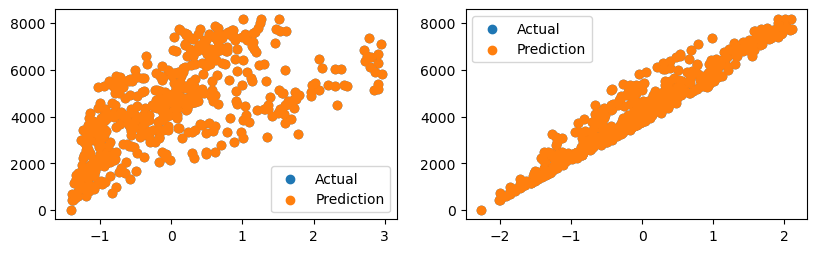



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 1.0
Residual Sum of Squares (RSS) on Training set  ---> 0.0
Mean Squared Error (MSE) on Training set       ---> 0.0
Root Mean Squared Error (RMSE) on Training set ---> 3.1945227e-13

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 1.0
Residual Sum of Squares (RSS) on Training set  ---> 0.0
Mean Squared Error (MSE) on Training set       ---> 0.0
Root Mean Squared Error (RMSE) on Training set ---> 3.1796203e-13

--------------------Residual Plots--------------------


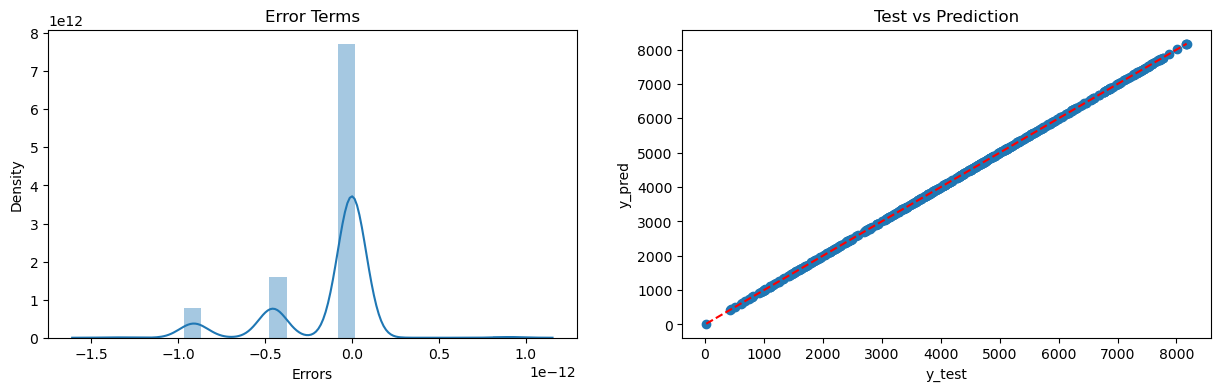

In [30]:
#Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

---

## 6b. Ridge Regression Model

<img src="https://raw.githubusercontent.com/Masterx-AI/Project_BoomBikes_Share_Prediction/main/ridge.png" style="width: 500px;float: left;"/>

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 516.39075268 1581.06834478]
The Intercept of the Regresion Model was found to be  4338.873370577281


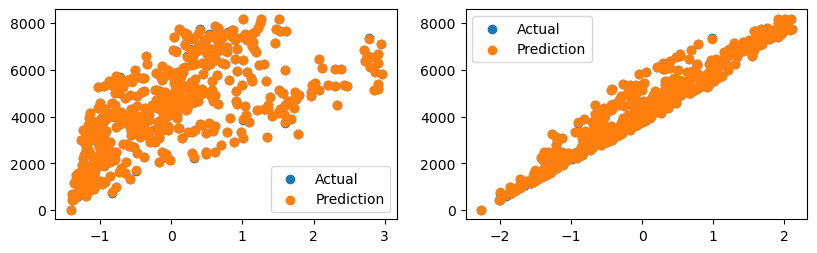



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9999974781597214
Residual Sum of Squares (RSS) on Training set  ---> 4695.9061972626205
Mean Squared Error (MSE) on Training set       ---> 8.744704277956462
Root Mean Squared Error (RMSE) on Training set ---> 2.9571446156649936

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.999997508603511
Residual Sum of Squares (RSS) on Training set  ---> 1150.0577012399017
Mean Squared Error (MSE) on Training set       ---> 8.518945935110382
Root Mean Squared Error (RMSE) on Training set ---> 2.9187233399399783

--------------------Residual Plots--------------------


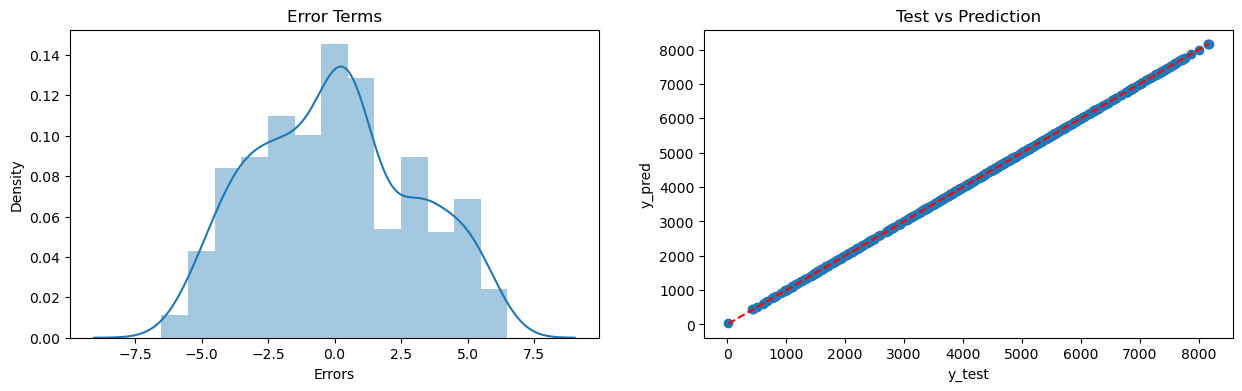

In [31]:
#Creating a Ridge Regression model

RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

---

## 6c. Lasso Regression Model

<img src="https://raw.githubusercontent.com/Masterx-AI/Project_BoomBikes_Share_Prediction/main/lasso.png" style="width: 500px;float: left;"/>

<<<----------------------------------- Evaluating Lasso Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 516.39075268 1581.06834478]
The Intercept of the Regresion Model was found to be  4338.873370577281


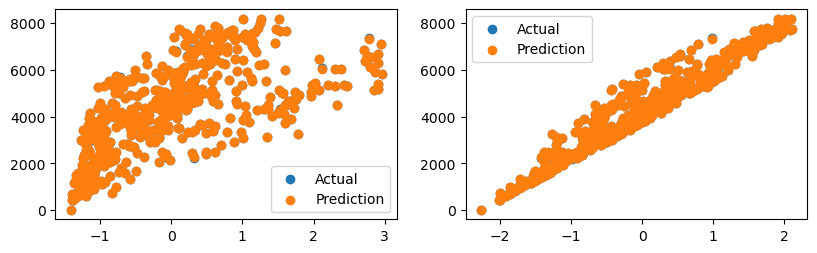



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9999996050993837
Residual Sum of Squares (RSS) on Training set  ---> 735.3424668627839
Mean Squared Error (MSE) on Training set       ---> 1.3693528246979216
Root Mean Squared Error (RMSE) on Training set ---> 1.170193498827404

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9999995863151233
Residual Sum of Squares (RSS) on Training set  ---> 190.9617680286661
Mean Squared Error (MSE) on Training set       ---> 1.4145316150271563
Root Mean Squared Error (RMSE) on Training set ---> 1.1893408321533219

--------------------Residual Plots--------------------


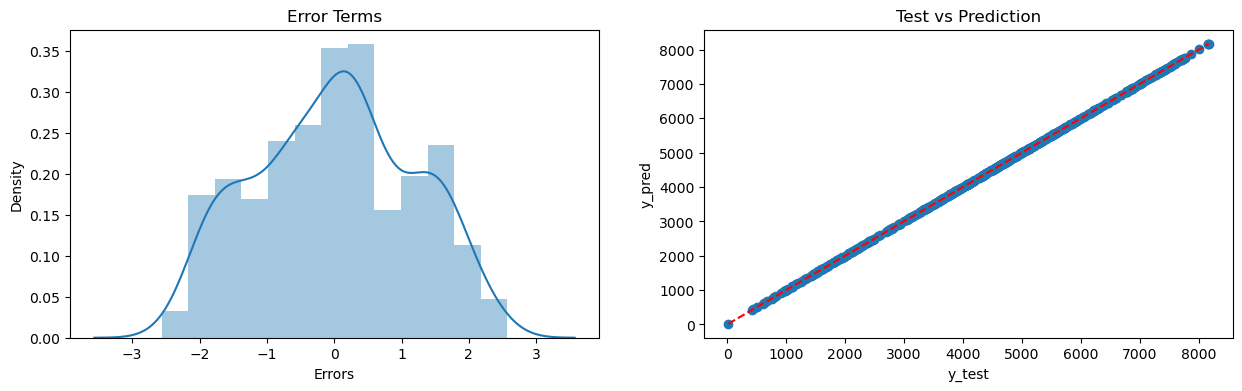

In [32]:
#Creating a Ridge Regression model

LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

---

## 6d. Elastic-Net Regression

<img src="https://raw.githubusercontent.com/Masterx-AI/Project_BoomBikes_Share_Prediction/main/en.png" style="width: 500px;float: left;"/>

<<<----------------------------------- Evaluating Elastic-Net Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 516.39075268 1581.06834478]
The Intercept of the Regresion Model was found to be  4338.873370577281


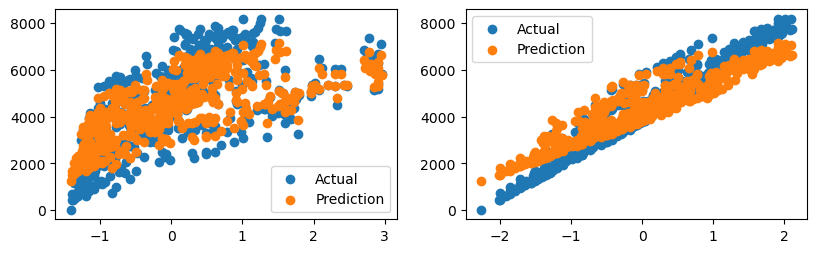



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9186470175174858
Residual Sum of Squares (RSS) on Training set  ---> 151486982.679617
Mean Squared Error (MSE) on Training set       ---> 282098.66420785285
Root Mean Squared Error (RMSE) on Training set ---> 531.1296114959632

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9193640445679679
Residual Sum of Squares (RSS) on Training set  ---> 37222498.285557985
Mean Squared Error (MSE) on Training set       ---> 275722.20952265174
Root Mean Squared Error (RMSE) on Training set ---> 525.0925723362041

--------------------Residual Plots--------------------


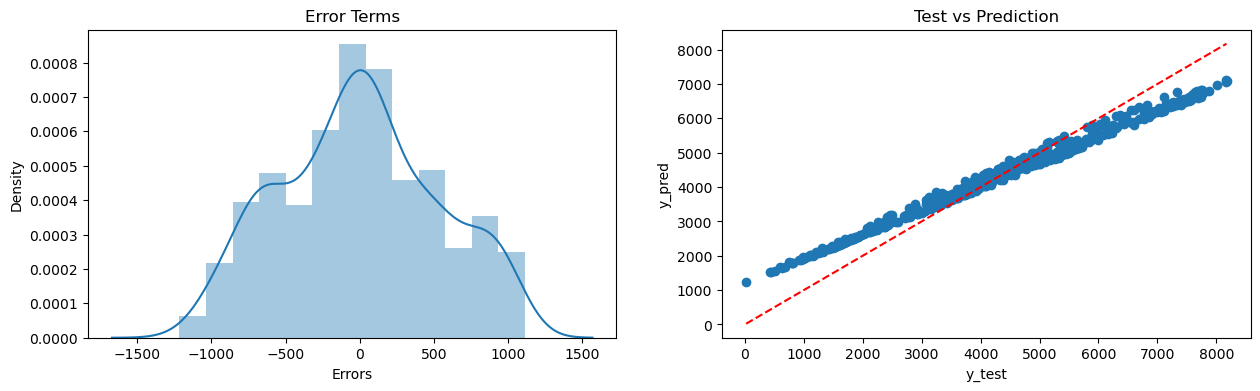

In [33]:
#Creating a ElasticNet Regression model

ENR = ElasticNet().fit(Train_X_std,Train_Y)
pred1 = ENR.predict(Train_X_std)
pred2 = ENR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Elastic-Net Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(3, pred1, pred2)

---

## 6e. Polynomial Regression Model

<img src="https://raw.githubusercontent.com/Masterx-AI/Project_BoomBikes_Share_Prediction/main/pn.png" style="width: 500px;float: left;"/>

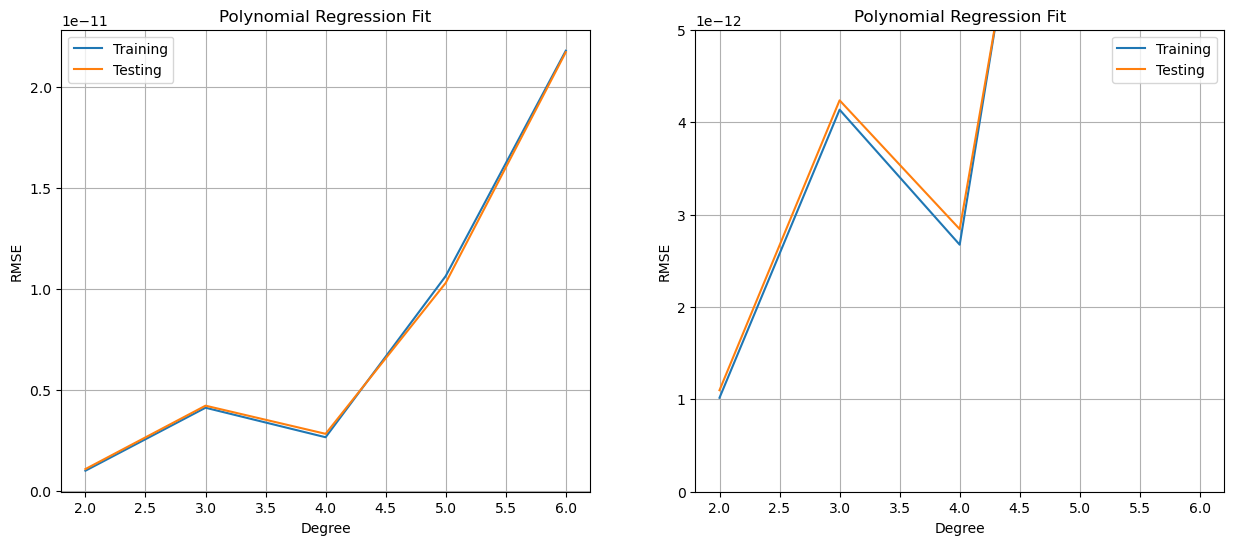

In [34]:
#Checking polynomial regression performance on various degrees

Trr=[]; Tss=[]
n_degree=7

for i in range(2,n_degree):
    #print(f'{i} Degree')
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)
    
    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
#plt.plot([1,4],[1,4],'b--')
plt.title('Polynomial Regression Fit')
#plt.ylim([0,5])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([0,5e-12])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()
plt.show()

**Inference:** We can choose 2nd order polynomial regression as it gives the optimal training & testing scores...

<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 516.39075268 1581.06834478]
The Intercept of the Regresion Model was found to be  4338.873370577281


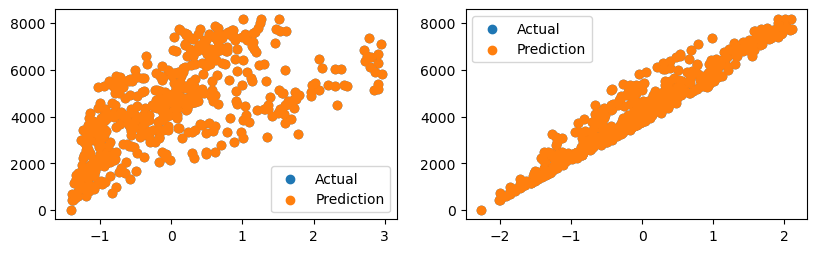



--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 1.0
Residual Sum of Squares (RSS) on Training set  ---> 0.0
Mean Squared Error (MSE) on Training set       ---> 0.0
Root Mean Squared Error (RMSE) on Training set ---> 1.01665661e-12

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 1.0
Residual Sum of Squares (RSS) on Training set  ---> 0.0
Mean Squared Error (MSE) on Training set       ---> 0.0
Root Mean Squared Error (RMSE) on Training set ---> 1.09866782e-12

--------------------Residual Plots--------------------


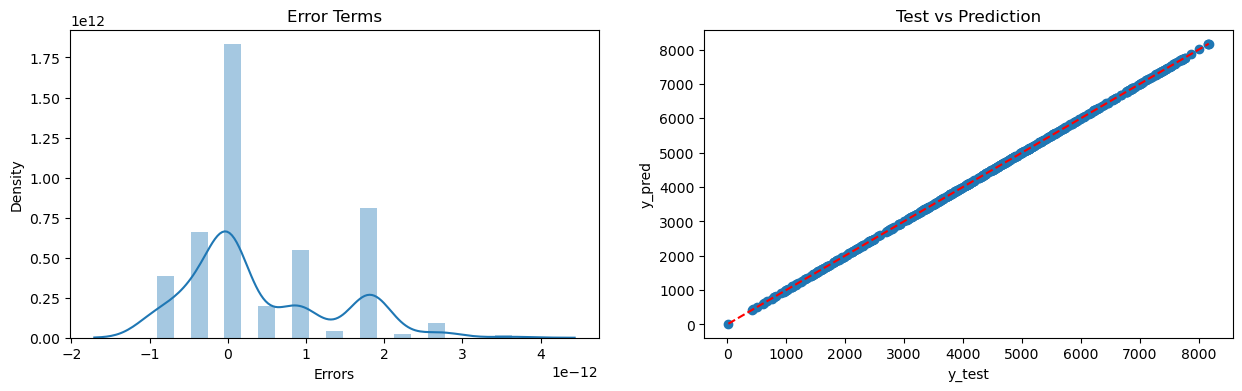

In [35]:
#Using the 2nd Order Polynomial Regression model (degree=2)

poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)

---

### 6f. Comparing the Evaluation Metics of the Models

In [36]:
# Regression Models Results Evaluation

EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)','Polynomial Regression (PNR)']
EMC

Train-R2   Test-R2     Train-RSS  \
Multiple Linear Regression (MLR)  1.000000  1.000000  0.000000e+00   
Ridge Linear Regression (RLR)     0.999997  0.999998  4.695906e+03   
Lasso Linear Regression (LLR)     1.000000  1.000000  7.353425e+02   
Elastic-Net Regression (ENR)      0.918647  0.919364  1.514870e+08   
Polynomial Regression (PNR)       1.000000  1.000000  0.000000e+00   

                                      Test-RSS      Train-MSE       Test-MSE  \
Multiple Linear Regression (MLR)  0.000000e+00       0.000000       0.000000   
Ridge Linear Regression (RLR)     1.150058e+03       8.744704       8.518946   
Lasso Linear Regression (LLR)     1.909618e+02       1.369353       1.414532   
Elastic-Net Regression (ENR)      3.722250e+07  282098.664208  275722.209523   
Polynomial Regression (PNR)       0.000000e+00       0.000000       0.000000   

                                    Train-RMSE     Test-RMSE  
Multiple Linear Regression (MLR)  3.194523e-13  3.179620e-13  
Ridge Linear Regression (RLR)     2.957145e+00  2.918723e+00  
Lasso Linear Regression (LLR)     1.170193e+00  1.189341e+00  
Elastic-Net Regression (ENR)      5.311296e+02  5.250926e+02  
Polynomial Regression (PNR)       1.016657e-12  1.098668e-12

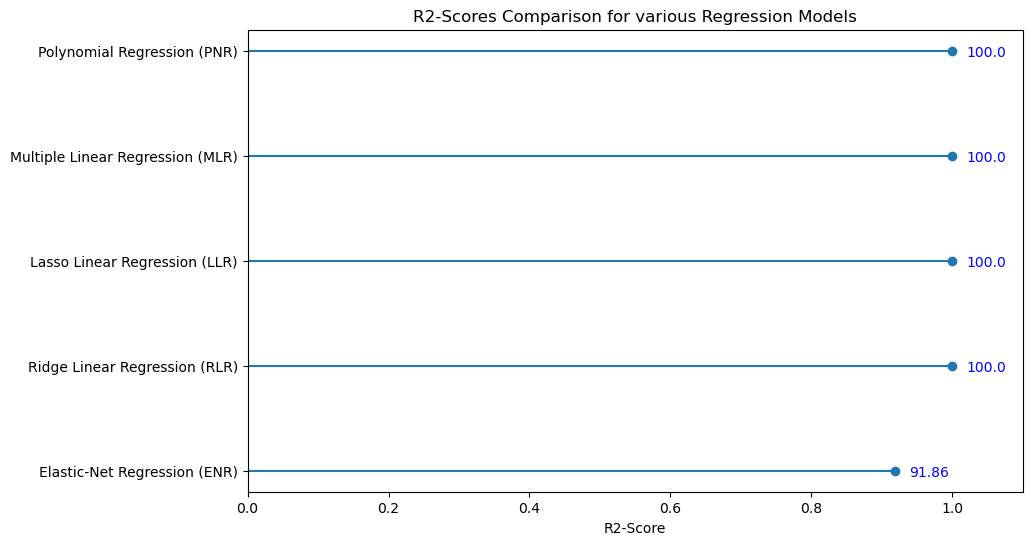

In [37]:
# R2-Scores Comparison for different Regression Models
R2 = round(EMC['Train-R2'].sort_values(ascending=True),4)
plt.hlines(y=R2.index, xmin=0, xmax=R2.values)
plt.plot(R2.values, R2.index,'o')
plt.title('R2-Scores Comparison for various Regression Models')
plt.xlabel('R2-Score')
for i, v in enumerate(R2):
    plt.text(v+0.02, i-0.05, str(v*100), color='blue')
plt.xlim([0,1.1])
plt.show()

**Inference:** From the above plot, it is clear that the polynomial regresion models have the highest explainability power  to understand the dataset.

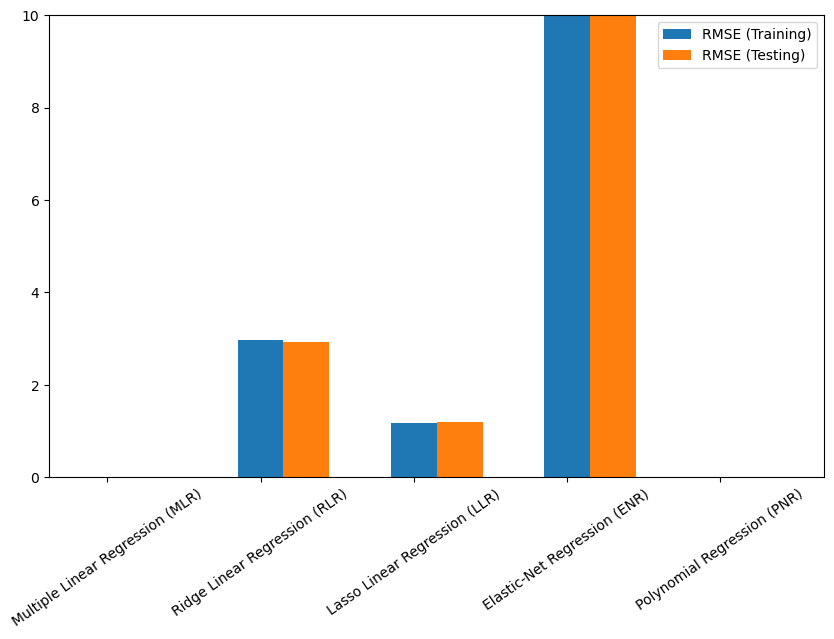

In [38]:
# Root Mean SquaredError Comparison for different Regression Models

cc = Model_Evaluation_Comparison_Matrix.columns.values
s=5
plt.bar(np.arange(5), Model_Evaluation_Comparison_Matrix[cc[6]].values, width=0.3, label='RMSE (Training)')
plt.bar(np.arange(5)+0.3, Model_Evaluation_Comparison_Matrix[cc[7]].values, width=0.3, label='RMSE (Testing)')
plt.xticks(np.arange(5),EMC.index, rotation =35)
plt.legend()
plt.ylim([0,10])
plt.show()

# <center> Project Outcomes & Conclusions

### Here are some of the key outcomes of the project:
- The Dataset was quiet small with just 730 samples & after preprocessing 7.9% of the datasamples were dropped. 
- Visualising the distribution of data & their relationships, helped us to get some insights on the feature-set.
- The features had high multicollinearity, hence in Feature Extraction step, we shortlisted the appropriate features with VIF Technique.
- Testing multiple algorithms with default hyperparamters gave us some understanding for various models performance on this specific dataset.
- While, Polynomial Regression (Order-2) was the best choise, yet it is safe to use multiple regression algorithm, as their scores were quiet comparable & also they're more generalisable.